<a href="https://colab.research.google.com/github/letianzj/QuantResearch/blob/master/notebooks/vector_autoregression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vector Autoregression expands 1D AR model into multi-variables. It is widely used in finance and economics. In reduced form, contemporary relationship is embedded in the error term; in structural form SVAR, the structural shocks are uncorrelated, and contemporary effects are explicitly given on the left side.

Below it uses VAR to investigate lead-lag relationships between prices and trading volume, including Granger causality and impulse responses. The process follows closely the [statsmodel documents here](https://www.statsmodels.org/stable/vector_ar.html?highlight=var#module-statsmodels.tsa.vector_ar.var_model).

In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import pandas_datareader as pdr

In [2]:
end_date = datetime.today()
# start_date = end_date + timedelta(days=-5*365)
start_date = datetime(2000, 1, 1)
spx = pdr.DataReader(name='^GSPC', data_source='yahoo', start=start_date, end=end_date)

In [3]:
price_chg = np.log(spx['Close']) - np.log(spx['Close'].shift(1))  # shift 1 shifts forward one day; today has yesterday's price
volume_chg = np.log(spx['Volume']) - np.log(spx['Volume'].shift(1))  # shift 1 shifts forward one day; today has yesterday's price
price_chg = price_chg * 100.0
volume_chg = volume_chg * 100.0
price_chg.dropna(inplace=True)
volume_chg.dropna(inplace=True)
print(price_chg.shape, volume_chg.shape)

(5155,) (5155,)


In [4]:
# Contemporaneous correlations between return and trading volume is less significant than absolute return and trading volume.
data = pd.merge(price_chg, volume_chg, left_index=True, right_index=True)
data.rename(columns={'Close': 'Price'}, inplace=True)
print(data.corr())
data = pd.merge(np.abs(price_chg), volume_chg, left_index=True, right_index=True)
data.rename(columns={'Close': 'Price'}, inplace=True)
print(data.corr())

           Price    Volume
Price   1.000000 -0.046082
Volume -0.046082  1.000000
           Price    Volume
Price   1.000000  0.114866
Volume  0.114866  1.000000


In [5]:
# train test split
data_training = data.iloc[:-22]
data_test = data.iloc[-22:]
model = VAR(data_training)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [6]:
ms = model.select_order(45)      # 45 business days, roughly two months
ms.summary()

,AIC,BIC,FPE,HQIC
0,5.766,5.768,319.1,5.766
1,5.540,5.548,254.7,5.543
2,5.359,5.372,212.5,5.363
3,5.287,5.305,197.8,5.293
4,5.243,5.266,189.1,5.251
5,5.204,5.232,182.0,5.214
6,5.182,5.215,178.0,5.194
7,5.168,5.206,175.5,5.181
8,5.153,5.197,173.0,5.168
9,5.143,5.191*,171.2,5.160


In [7]:
results  = model.fit(maxlags=45, ic='aic')

In [8]:
# best lag order is 32, around 6 weeks
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 01, Jul, 2020
Time:                     00:57:56
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    5.26514
Nobs:                     5101.00    HQIC:                   5.15687
Log likelihood:          -27349.8    FPE:                    163.783
AIC:                      5.09854    Det(Omega_mle):         159.687
--------------------------------------------------------------------
Results for equation Price
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.105441         0.020081            5.251           0.000
L1.Price           0.016185         0.014407            1.123           0.261
L1.Volume          0.002203         0.000700            3.149           

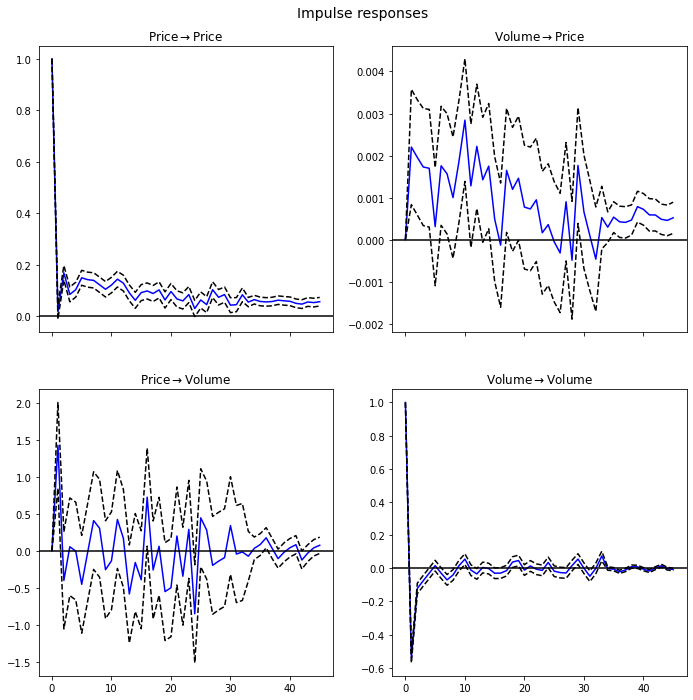

In [11]:
# volume --> price has positive shocks which dies out over time; which matches our intuition.
# volume --> volume has negative shocks; suggests mean reversion
irf = results.irf(45)
irf.plot(orth=False);
# irf.plot(impulse='Volume');

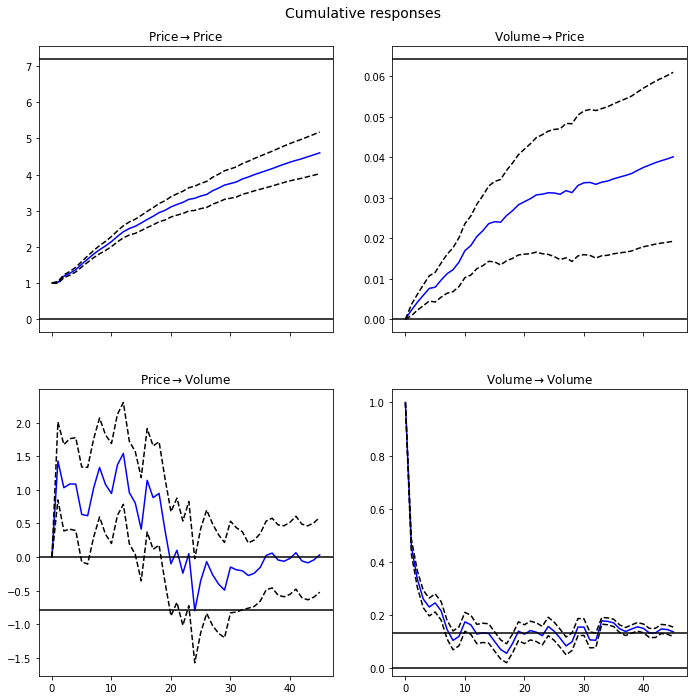

In [12]:
irf.plot_cum_effects(orth=False);

In [13]:
# autocorrelation with itself dominates
fevd = results.fevd(10)
fevd.summary()
results.fevd(20).plot();

FEVD for Price
        Price    Volume
0    1.000000  0.000000
1    0.998046  0.001954
2    0.996615  0.003385
3    0.995493  0.004507
4    0.994449  0.005551
5    0.994529  0.005471
6    0.993517  0.006483
7    0.992766  0.007234
8    0.992516  0.007484
9    0.991393  0.008607

FEVD for Volume
        Price    Volume
0    0.043947  0.956053
1    0.035762  0.964238
2    0.036874  0.963126
3    0.036846  0.963154
4    0.036852  0.963148
5    0.037104  0.962896
6    0.037118  0.962882
7    0.037003  0.962997
8    0.036988  0.963012
9    0.037044  0.962956




In [14]:
gc = results.test_causality('Price', ['Price', 'Volume'], kind='f')
gc.summary()

Test statistic,Critical value,p-value,df
37.07,1.309,0.000,"(64, 10072)"


In [16]:
# H_0 rejected; Volume has incremental explanation power.
gc = results.test_causality('Price', ['Volume'], kind='f')
gc.summary()

Test statistic,Critical value,p-value,df
1.651,1.445,0.012,"(32, 10072)"


In [18]:
# Normality is rejected; the model needs improvements; probably GARCH.
nt = results.test_normality()
nt.summary()

Test statistic,Critical value,p-value,df
5.535e+04,9.488,0.000,4


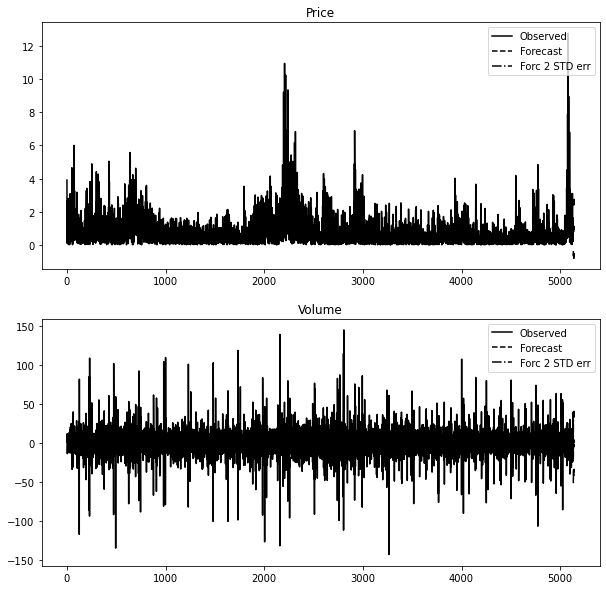

In [21]:
# forecast
results.plot_forecast(10);

In [29]:
lag_order = results.k_ar
# results.forecast(data.values[-lag_order:], 5)
m, l, u = results.forecast_interval(data.values[-lag_order:], data_test.shape[0])

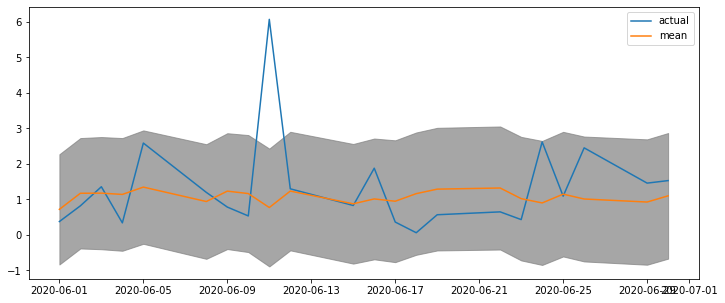

In [45]:
# Return forecast
plt.figure(figsize=(12, 5))
plt.plot(data_test['Price'], label='actual')
plt.plot(pd.DataFrame(m[:, 0], index=data_test.index), label='mean')
plt.fill_between(data_test.index, l[:, 0], u[:, 0], color='gray', alpha=0.7)
plt.legend()
plt.show()

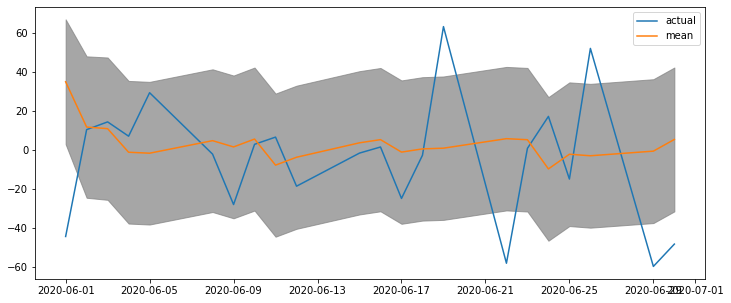

In [46]:
# volume forecast
plt.figure(figsize=(12, 5))
plt.plot(data_test['Volume'], label='actual')
plt.plot(pd.DataFrame(m[:, 1], index=data_test.index), label='mean')
plt.fill_between(data_test.index, l[:, 1], u[:, 1], color='gray', alpha=0.7)
plt.legend()
plt.show()